In [1]:
import pandas as pd # type: ignore
from datetime import datetime # type: ignore
import numpy as np #type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from keras.optimizers import Adam # type: ignore
from matplotlib import pyplot as plt # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
import seaborn as sns # type: ignore

In [2]:
df = pd.read_csv('datasets/dataset_PS.csv')
df = df.astype({'date': 'datetime64[ns]'})
# df.drop(columns=['irradiation', 'cloudiness', 'holiday', 'precipitation'], inplace=True)
df['shifted_consumption_168'] = df['consumption'].shift(168)
df['shifted_consumption_48'] = df['consumption'].shift(48)
df['hour'] = df['date'].dt.hour
df['weekDay'] = df['date'].dt.weekday
df = df.fillna(df.mean())
df.head()

,date,consumption,temperature,precipitation,irradiation,cloudiness,holiday,shifted_consumption_168,shifted_consumption_48,hour,weekDay
0,2022-01-01 01:00:00,1018.0,-3.2,0.0,0.0,37.0,1.0,1295.358621,1295.144189,1,5
1,2022-01-01 02:00:00,975.0,-3.9,0.0,0.0,37.0,1.0,1295.358621,1295.144189,2,5
2,2022-01-01 03:00:00,944.0,-2.8,0.0,0.0,37.0,1.0,1295.358621,1295.144189,3,5
3,2022-01-01 04:00:00,936.0,-3.1,0.0,0.0,37.0,1.0,1295.358621,1295.144189,4,5
4,2022-01-01 05:00:00,952.0,-4.1,0.0,0.0,37.0,1.0,1295.358621,1295.144189,5,5


In [3]:
# remove last week of data
df = df.iloc[:-168]
df.tail()

,date,consumption,temperature,precipitation,irradiation,cloudiness,holiday,shifted_consumption_168,shifted_consumption_48,hour,weekDay
24447,2024-10-16 19:00:00,1627.0,11.9,0.0,0.0,97.0,0.0,1608.0,1536.0,19,2
24448,2024-10-16 20:00:00,1601.0,11.5,0.0,0.0,97.0,0.0,1551.0,1497.0,20,2
24449,2024-10-16 21:00:00,1452.0,11.2,0.0,0.0,97.0,0.0,1445.0,1394.0,21,2
24450,2024-10-16 22:00:00,1330.0,10.9,0.2,0.0,97.0,0.0,1335.0,1288.0,22,2
24451,2024-10-16 23:00:00,1228.0,10.7,0.4,0.0,97.0,0.0,1199.0,1166.0,23,2


In [31]:
# extract dates from the dataframe
df_dates = list(df['date'])
print(df_dates[0:5])

[Timestamp('2022-01-01 01:00:00'), Timestamp('2022-01-01 02:00:00'), Timestamp('2022-01-01 03:00:00'), Timestamp('2022-01-01 04:00:00'), Timestamp('2022-01-01 05:00:00')]


In [32]:
# columns used from training dataset
cols = list(df)[1:3]
df_for_training = df[cols].astype(float)
df_for_training.head()

,consumption,temperature
0,1018.0,-3.2
1,975.0,-3.9
2,944.0,-2.8
3,936.0,-3.1
4,952.0,-4.1


<Axes: >

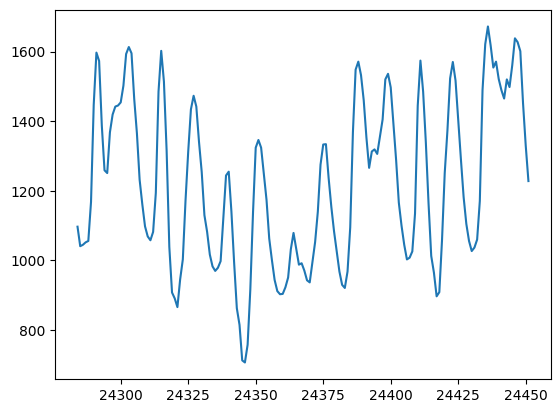

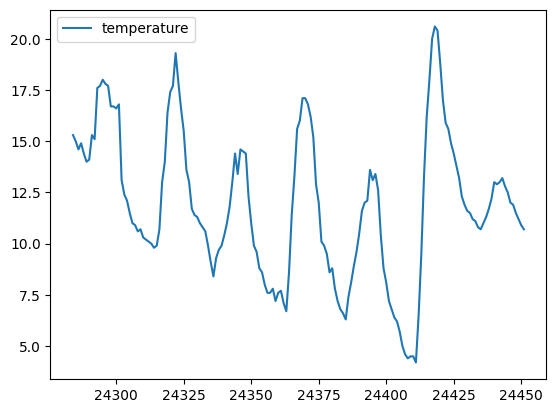

In [33]:
df_for_training.iloc[:, 0].tail(168).plot.line()
df_for_training.iloc[:, 1:4].tail(168).plot.line()

In [34]:
# scaling the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled

array([[0.46890834, 0.23954373],
       [0.4491018 , 0.22623574],
       [0.43482266, 0.24714829],
       ...,
       [0.66881621, 0.51330798],
       [0.61262091, 0.50760456],
       [0.56563795, 0.50380228]])

In [35]:
# creating the trainX and trainY
trainX = []
trainY = []

n_future = 1 # number of hours we want to predict into the future
n_past = 168 # 168 hours, because of weekly variation

for i in range(n_past, len(df_for_training_scaled) - n_future + 1): # from 168 to the end without going out of bounds
	trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]]) # from 168 to the end
	trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0]) # from 168 to the end

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (24284, 168, 2).
trainY shape == (24284, 1).


In [36]:
# defining the model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 168, 64)        │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - loss: 0.0643 - val_loss: 0.0099
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - loss: 0.0155 - val_loss: 0.0084
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - loss: 0.0117 - val_loss: 0.0040
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - loss: 0.0068 - val_loss: 0.0020
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 9/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 95ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 10/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - loss: 0.0023 - val_loss: 0.0016


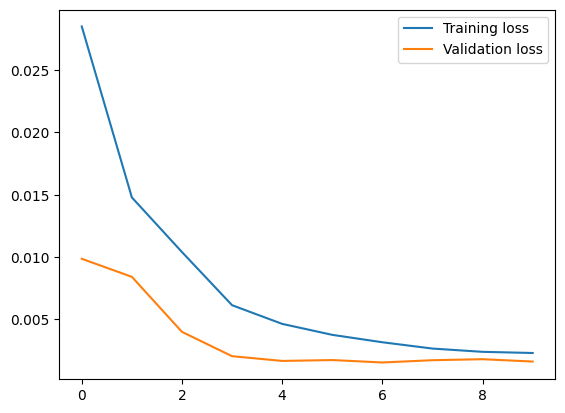

In [38]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [39]:
n_past = 168
n_days_for_prediction= 168

In [40]:
cutoff_date = '2024-10-17 00:00:00'

In [41]:
predict_period_dates = pd.date_range(cutoff_date, periods=n_days_for_prediction, freq='h').tolist()
print(predict_period_dates)

[Timestamp('2024-10-17 00:00:00'), Timestamp('2024-10-17 01:00:00'), Timestamp('2024-10-17 02:00:00'), Timestamp('2024-10-17 03:00:00'), Timestamp('2024-10-17 04:00:00'), Timestamp('2024-10-17 05:00:00'), Timestamp('2024-10-17 06:00:00'), Timestamp('2024-10-17 07:00:00'), Timestamp('2024-10-17 08:00:00'), Timestamp('2024-10-17 09:00:00'), Timestamp('2024-10-17 10:00:00'), Timestamp('2024-10-17 11:00:00'), Timestamp('2024-10-17 12:00:00'), Timestamp('2024-10-17 13:00:00'), Timestamp('2024-10-17 14:00:00'), Timestamp('2024-10-17 15:00:00'), Timestamp('2024-10-17 16:00:00'), Timestamp('2024-10-17 17:00:00'), Timestamp('2024-10-17 18:00:00'), Timestamp('2024-10-17 19:00:00'), Timestamp('2024-10-17 20:00:00'), Timestamp('2024-10-17 21:00:00'), Timestamp('2024-10-17 22:00:00'), Timestamp('2024-10-17 23:00:00'), Timestamp('2024-10-18 00:00:00'), Timestamp('2024-10-18 01:00:00'), Timestamp('2024-10-18 02:00:00'), Timestamp('2024-10-18 03:00:00'), Timestamp('2024-10-18 04:00:00'), Timestamp('20

In [42]:
prediction = model.predict(trainX[-n_days_for_prediction:])

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


In [43]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [44]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i)

In [45]:
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'consumption':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])
df_forecast.head()

,date,consumption
0,2024-10-17 00:00:00,1132.789673
1,2024-10-17 01:00:00,1067.031860
2,2024-10-17 02:00:00,1027.468750
3,2024-10-17 03:00:00,1032.906372
4,2024-10-17 04:00:00,1087.959717


In [46]:
original = pd.read_csv('forecasts/actuals.csv')
original['date'] = original['date'].astype({'date': 'datetime64[ns]'})
original.head()

,date,consumption
0,2024-10-17 00:00:00,1141.0
1,2024-10-17 01:00:00,1097.0
2,2024-10-17 02:00:00,1062.0
3,2024-10-17 03:00:00,1083.0
4,2024-10-17 04:00:00,1101.0


In [47]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error # type: ignore
from sktime.performance_metrics.forecasting import mean_squared_percentage_error # type: ignore

mse = root_mean_squared_error(original['consumption'], df_forecast['consumption'])
mae = mean_absolute_error(original['consumption'], df_forecast['consumption'])
mape = mean_absolute_percentage_error(original['consumption'], df_forecast['consumption'])
rmspe = mean_squared_percentage_error(original['consumption'], df_forecast['consumption'], square_root=True)

plt_title = 'MAE: {0:.2f}, RMSE: {1:.2f}, MAPE: {2:.2f}, RMSPE: {3:.2f}'.format(mae, mse, mape*100, rmspe*100)

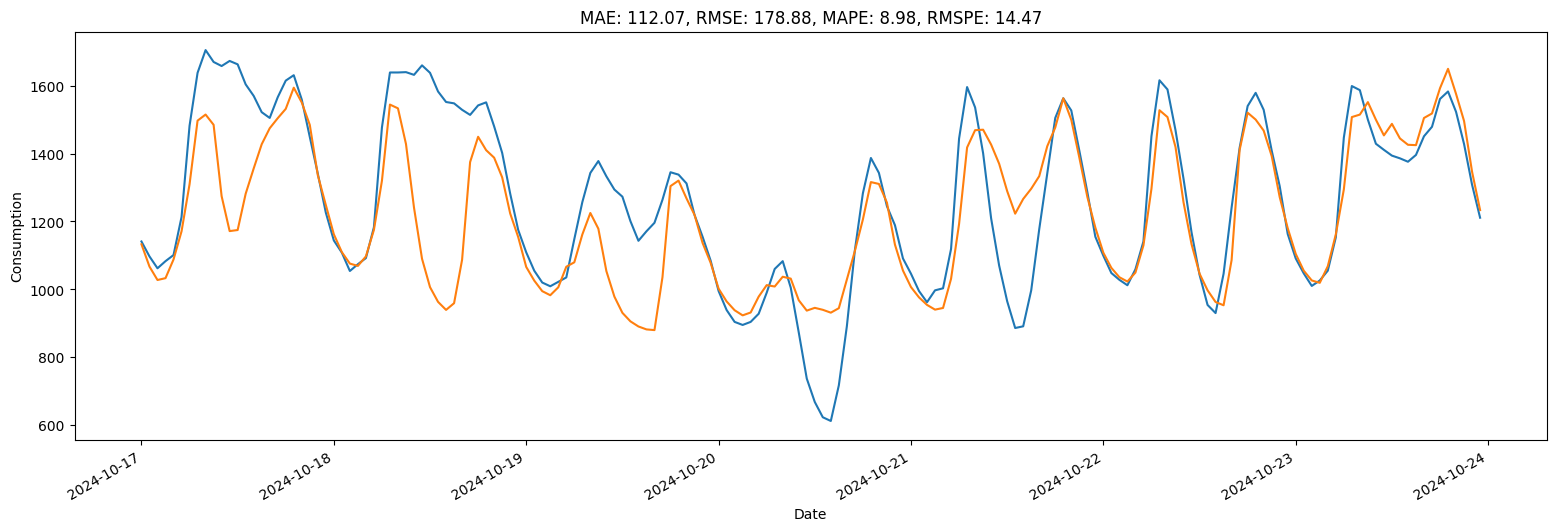

In [48]:
plt.plot(original['date'], original['consumption'])
plt.plot(df_forecast['date'], df_forecast['consumption'])
# change axis date format
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title(plt_title)
# set figsize to (19, 6)
plt.gcf().set_size_inches(19, 6)

1 <br>
MAE: 112.01, RMSE: 185.12, MAPE: 9.08, RMSPE: 15.33<br>
consumption	temperature	precipitation	irradiation	cloudiness	holiday	shifted_consumption_168	shifted_consumption_48	hour	weekDay

2 <br>
MAE: 127.40, RMSE: 193.21, MAPE: 10.17, RMSPE: 15.69<br>
consumption	temperature	precipitation	irradiation	cloudiness	holiday

3 <br>
MAE: 112.07, RMSE: 179.88, MAPE: 8.98, RMSPE: 14.47<br>
consumption	temperature

In [50]:
df_forecast.to_csv('forecasts/forecast_LTSM_2.csv', index=False)